In [3]:
import tensorflow as tf

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2

# from spektral.layers import GraphConv
# GRaphConv is deprecated, use GCNConv or GCSConv instead
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian
from spektral.layers import GCSConv  # as GraphConv
from spektral.layers import GINConv # as GraphConv
from spektral.layers import GCNConv  # as GraphConv

from spektral.utils.convolution import gcn_filter  # For GCNConv
from spektral.utils.convolution import normalized_adjacency  # For GCSConv

import numpy as np
import scipy.sparse
import pandas as pd
import pathlib
import os
import json

from sklearn.model_selection import train_test_split

from utils import *

import numpy as np

2023-12-06 14:52:22.055137: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 14:52:22.089115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 14:52:22.089140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 14:52:22.089865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 14:52:22.096579: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 14:52:22.097253: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
# Parameters
l2_reg = 5e-4  # Regularization rate for l2
learning_rate = 1e-3  # Learning rate for SGD
batch_size = 32  # Batch size
epochs = 5  # Number of training epochs
es_patience = 200  # Patience fot early stopping

In [5]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [6]:
current_path = pathlib.Path().absolute()
path = current_path.parent

In [7]:
angry_path = path / 'angry_meshpoints'
disgusted_path = path / 'disgusted_meshpoints'
happy_path = path / 'happy_meshpoints'
neutral_path = path / 'neutral_meshpoints'
sad_path = path / 'sad_meshpoints'
surprised_path = path / 'surprised_meshpoints'

path_list = [angry_path, disgusted_path, happy_path, neutral_path, sad_path, surprised_path]

In [8]:
def extrai_dist(path_list, meshs_list, limit=0.1):
    for path in path_list:
        quant_files = len(os.listdir(path))
        count = 0
        for file in os.listdir(path):
            if (count / quant_files) > limit:
                break
            file_path = path / file
            count += 1
            with open(file_path, 'r') as f:
                data = json.load(f)
                meshs_list[path_list.index(path)].append(data)

In [9]:
meshs_surprised = []
meshs_disgusted = []
meshs_happy = []
meshs_neutral = []
meshs_sad = []
meshs_angry = []

meshs_list = [meshs_angry, meshs_disgusted, meshs_happy, meshs_neutral, meshs_sad, meshs_surprised]

extrai_dist(path_list, meshs_list, 0.1)

print(len(meshs_angry))
print(len(meshs_disgusted))
print(len(meshs_happy))
print(len(meshs_neutral))
print(len(meshs_sad))
print(len(meshs_surprised))

446
161
810
687
742
402


In [10]:
# print(meshs_list)

In [11]:
print(len(meshs_list))

6


In [12]:
# target list
target_list = []
for i in range(6):
    target_list.append(np.full(len(meshs_list[i]), i))

In [13]:
# print(target_list)

In [14]:
# print the unique target labels
print(np.unique(np.concatenate(target_list)))

[0 1 2 3 4 5]


In [15]:
# concatena meshs_list em uma lista só
meshs_list_concat = np.concatenate(meshs_list)
target_list_concat = np.concatenate(target_list)

print(len(meshs_list_concat))

3248


# Iniciando a construção do primeiro GINConv

In [16]:
from sklearn.model_selection import train_test_split


# Split the dataset into train and test sets, shuffling the data
X_train, X_test, y_train, y_test = train_test_split(meshs_list_concat, target_list_concat, test_size=0.1, shuffle=True, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42)

In [17]:
# import concat from tensorflow
from tensorflow import concat

# tensor_mesh = concat(meshs_list, axis=0)
# target_tensor = concat(target_list, axis=0)

X__train_tensor = concat(X_train, axis=0)
y__train_tensor = concat(y_train, axis=0)

X__val_tensor = concat(X_val, axis=0)
y__val_tensor = concat(y_val, axis=0)

X__test_tensor = concat(X_test, axis=0)
y__test_tensor = concat(y_test, axis=0)

2023-12-06 14:52:54.301355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 14:52:54.301759: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
for target_tensor in [y__train_tensor, y__val_tensor, y__test_tensor]:
    unique_values = np.unique(target_tensor.numpy())
    print("Unique values in target tensor:")
    print(unique_values)
    print()

Unique values in target tensor:
[0 1 2 3 4 5]

Unique values in target tensor:
[0 1 2 3 4 5]

Unique values in target tensor:
[0 1 2 3 4 5]



In [19]:
# tensor_mesh.shape
X__train_tensor.shape

TensorShape([2630, 478, 2])

In [20]:
# target_tensor.shape
y__train_tensor.shape

TensorShape([2630])

In [21]:
X__val_tensor.shape

TensorShape([293, 478, 2])

In [22]:
y__val_tensor.shape

TensorShape([293])

In [23]:
n_out = 6  # Number of classes
N = X__train_tensor.shape[-2]  # Number of nodes in the graphs
F = X__train_tensor.shape[-1]  # Original feature dimensionality

In [24]:
N, F

(478, 2)

In [25]:
adj = tf.sparse.from_dense(tf.convert_to_tensor(get_mediapipe_adjacency_matrix()))

X_in = Input(shape=(N, F))

graph_conv_1 = GINConv(32, activation="elu", kernel_regularizer=l2(l2_reg), use_bias=True)([X_in, adj])
graph_conv_2 = GINConv(32, activation="elu", kernel_regularizer=l2(l2_reg), use_bias=True)([graph_conv_1, adj])
flatten = Flatten()(graph_conv_2)
fc = Dense(512, activation="relu")(flatten)
output = Dense(n_out, activation="softmax")(fc)

In [26]:
# Build model
model = Model(inputs=X_in, outputs=output)
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"]
)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 478, 2)]          0         
                                                                 
 gin_conv (GINConv)          (None, 478, 32)           97        
                                                                 
 gin_conv_1 (GINConv)        (None, 478, 32)           1057      
                                                                 
 flatten (Flatten)           (None, 15296)             0         
                                                                 
 dense (Dense)               (None, 512)               7832064   
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 7836296 (29.89 MB)
Trainable params: 7836296 (2

In [28]:
# o tensor_mesh é um tensor de dimensão 3
# o sparse_matrix é um tensor de dimensão 2
# o target_list é um tensor de dimensão 1

# Train model
history = model.fit(
    X__train_tensor,
    y__train_tensor,
    batch_size=batch_size,
    validation_data=(X__val_tensor, y__val_tensor),
    epochs=20,
    callbacks=[EarlyStopping(patience=es_patience)],
)

Epoch 1/20
83/83 [==============================] - 10s 103ms/step - loss: 6977.4404 - acc: 0.2529 - val_loss: 1820.9868 - val_acc: 0.1945
Epoch 2/20
83/83 [==============================] - 8s 98ms/step - loss: 716.0045 - acc: 0.3236 - val_loss: 346.5353 - val_acc: 0.2969
Epoch 3/20
83/83 [==============================] - 8s 97ms/step - loss: 346.1017 - acc: 0.3217 - val_loss: 206.5306 - val_acc: 0.3140
Epoch 4/20
83/83 [==============================] - 8s 97ms/step - loss: 70.9466 - acc: 0.3901 - val_loss: 86.0433 - val_acc: 0.3413
Epoch 5/20
83/83 [==============================] - 8s 98ms/step - loss: 25.4312 - acc: 0.4376 - val_loss: 12.5024 - val_acc: 0.4300
Epoch 6/20
83/83 [==============================] - 8s 98ms/step - loss: 9.1206 - acc: 0.4646 - val_loss: 8.2660 - val_acc: 0.5017
Epoch 7/20
83/83 [==============================] - 8s 98ms/step - loss: 4.5796 - acc: 0.5118 - val_loss: 3.8046 - val_acc: 0.4676
Epoch 8/20
83/83 [==============================] - 8s 98ms/ste

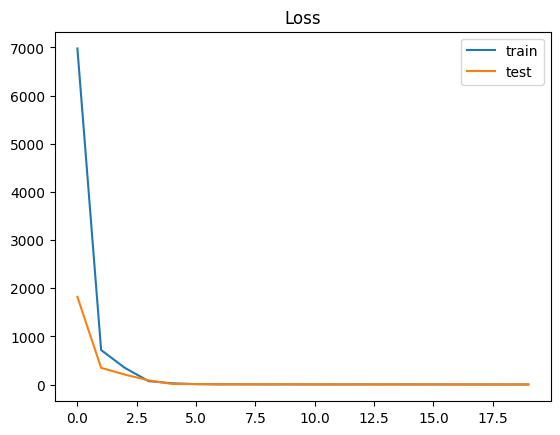

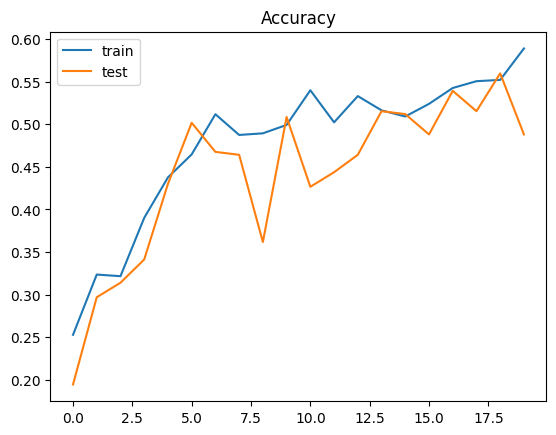

In [29]:
# ploting the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(history.history["acc"], label="train")
plt.plot(history.history["val_acc"], label="test")
plt.title("Accuracy")
plt.legend()
plt.show()

Como o dempenho caiu muita rápido através das epochs, pode ser que o modelo esteja com um overfitting muito grande.

10/10 [==============================] - 0s 15ms/step


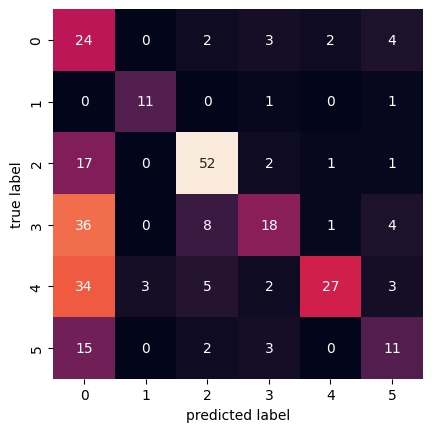

In [32]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X__val_tensor)
y_pred = np.argmax(y_pred, axis=-1)
y_true = y__val_tensor

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt="d", cbar=False)
plt.ylabel("true label")
plt.xlabel("predicted label")
plt.show()

Ta.... ta uma bosta